## Compare different losses and test tasks

In [ ]:
%load_ext autoreload
%autoreload 2
from transformer_lens import HookedTransformer, ActivationCache
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import pickle

from tasks import OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tqdm.auto import tqdm

In [ ]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM
reference_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token_id = tokenizer.eos_token_id

## Train with different losses

In [ ]:
# compare Gradient Ascent (-IOITask[CE] + OWT), HarmBench Loss (IOITask[1MP] + OWT), NPO Loss (IOITask_NPO), NPO+SFT Loss (IOITask_NPO + OWT), Uniform_all Loss (IOITask_Uniform[all_tokens] + OWT), Uniform_exclude Loss (IOITask_Uniform[exclude_correct] + OWT)

batch_size = 80
device = "cuda"
train_loss_type = "ioi"

if train_loss_type == "ioi":
    ioi_ce = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="cross_entropy")
    ioi_1mp = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="log_1_minus_p")
    ioi_npo = IOITask_NPO(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", ref_model=reference_gpt2, beta=1)
    ioi_uniform = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=False)
    ioi_uniform_exclude = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=True)
    ioi_uniform_specific = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="IO_S", nb_templates=4, prompt_type="ABBA", exclude_correct=False)

elif train_loss_type == "induction":
    induction_ce = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="cross_entropy")
    induction_1mp = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="log_1_minus_p")
    induction_npo = InductionTask_NPO(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="npo", ref_model=reference_gpt2, beta=1)
    induction_uniform = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", criterion="cross_entropy", exclude_correct=False)
    induction_uniform_exclude = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", criterion="cross_entropy", exclude_correct=True)
    induction_uniform_specific = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="IO_S", criterion="cross_entropy", exclude_correct=False)


owt = OWTTask(batch_size=batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

eval_batch_size=160
greaterthan_eval = GreaterThanTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device)
ioi_eval = IOITask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA")
induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
eval_tasks = {"ioi": ioi_eval, "induction": induction_eval, "owt": owt, "greaterthan": greaterthan_eval}

## Test ioi_1mp

In [ ]:
test_model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
print(ioi_eval.get_test_loss(test_model))
print(ioi_1mp.get_test_loss(test_model))
print(ioi_npo.get_test_loss(test_model))

In [ ]:
from cb_utils.learn_mask import evaluate_model
def train_loop(model, optimizer, num_epochs, train_tasks, train_task_weights, eval_tasks, eval_every=1, num_steps_per_epoch=100, eval_iters=4):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        for step in range(num_steps_per_epoch):
            optimizer.zero_grad()
            train_loss = {}
            for task_name in train_tasks:
                task = train_tasks[task_name]
                task_weight = train_task_weights[task_name]
                loss = task.get_train_loss(model)
                train_loss[task_name] = loss.item()
                loss = loss * task_weight
                loss.backward()
            optimizer.step()
            train_losses.append(train_loss)

        if epoch % eval_every == 0:
            test_loss = evaluate_model(model, eval_tasks, num_eval_steps=eval_iters)
            test_losses.append(test_loss)
    return train_losses, test_losses

In [ ]:
num_epochs = 50
steps_per_epoch = 10
lr = 1e-2
wd = 0
if train_loss_type == "ioi":
    loss_types = {
        "Cross Entropy": ({'ioi': ioi_ce, 'owt': owt}, {'ioi': -.2, 'owt': 1}), 
        "Log 1 Minus P": ({'ioi_1mp': ioi_1mp, 'owt': owt}, {'ioi_1mp': .2, 'owt': 1}), 
        "NPO": ({'ioi_npo': ioi_npo}, {'ioi_npo': .2}), 
        "NPO SFT": ({'ioi_npo': ioi_npo, 'owt': owt}, {'ioi_npo': .2, 'owt': 1}), 
        "Uniform Over All": ({'ioi_uniform': ioi_uniform, 'owt': owt}, {'ioi_uniform': .2, 'owt': 1}), 
        "Uniform Excluding Correct": ({'ioi_uniform_exclude': ioi_uniform_exclude, 'owt': owt}, {'ioi_uniform_exclude': .2, 'owt': 1}), 
        "Uniform Over Specific": ({'ioi_uniform_specific': ioi_uniform_specific, 'owt': owt}, {'ioi_uniform_specific': .2, 'owt': 1})
    }
elif train_loss_type == "induction":
    loss_types = {
        "Cross Entropy": ({'induction_ce': induction_ce, 'owt': owt}, {'induction_ce': -.2, 'owt': 1}), 
        "Log 1 Minus P": ({'induction_1mp': induction_1mp, 'owt': owt}, {'induction_1mp': .2, 'owt': 1}), 
        "NPO": ({'induction_npo': induction_npo}, {'induction_npo': .2}), 
        "NPO SFT": ({'induction_npo': induction_npo, 'owt': owt}, {'induction_npo': .2, 'owt': 1}), 
        "Uniform Over All": ({'induction_uniform': induction_uniform, 'owt': owt}, {'induction_uniform': .2, 'owt': 1}), 
        "Uniform Excluding Correct": ({'induction_uniform_exclude': induction_uniform_exclude, 'owt': owt}, {'induction_uniform_exclude': .2, 'owt': 1}), 
        "Uniform Over Specific": ({'induction_uniform_specific': induction_uniform_specific, 'owt': owt}, {'induction_uniform_specific': .2, 'owt': 1})
    }

all_train_losses = {}
all_test_losses = {}
for loss_name in tqdm(loss_types):
    train_tasks, task_weights = loss_types[loss_name]
    model = AutoModelForCausalLM.from_pretrained("gpt2")
    model.cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    train_losses, test_losses = train_loop(model, optimizer, num_epochs, train_tasks, task_weights, eval_tasks, num_steps_per_epoch=steps_per_epoch)
    all_train_losses[loss_name] = train_losses
    all_test_losses[loss_name] = test_losses
    model.cpu()

with open(f"results/{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
    pickle.dump((all_train_losses, all_test_losses), f)



## Analyze Losses

In [ ]:
# import pickle
# with open(f"results/ioi_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses, all_test_losses = pickle.load(f)

# with open("results/ioi_npo_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses_npo, all_test_losses_npo = pickle.load(f)

# # update all_train_losses with items from all_train_losses_npo, all_test_losses with items from all_test_losses_npo
# for loss_name in all_train_losses_npo:
#     all_train_losses[loss_name] = all_train_losses_npo[loss_name]
#     all_test_losses[loss_name] = all_test_losses_npo[loss_name]

# with open("results/ioi_lr=0.001_loss_type_sweep_losses.pkl", "wb") as f:
#     pickle.dump((all_train_losses, all_test_losses), f)

In [55]:
import pickle
lr=1e-4
with open(f"results/{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "rb") as f:
    all_train_losses, all_test_losses = pickle.load(f)

In [56]:
lr

0.0001

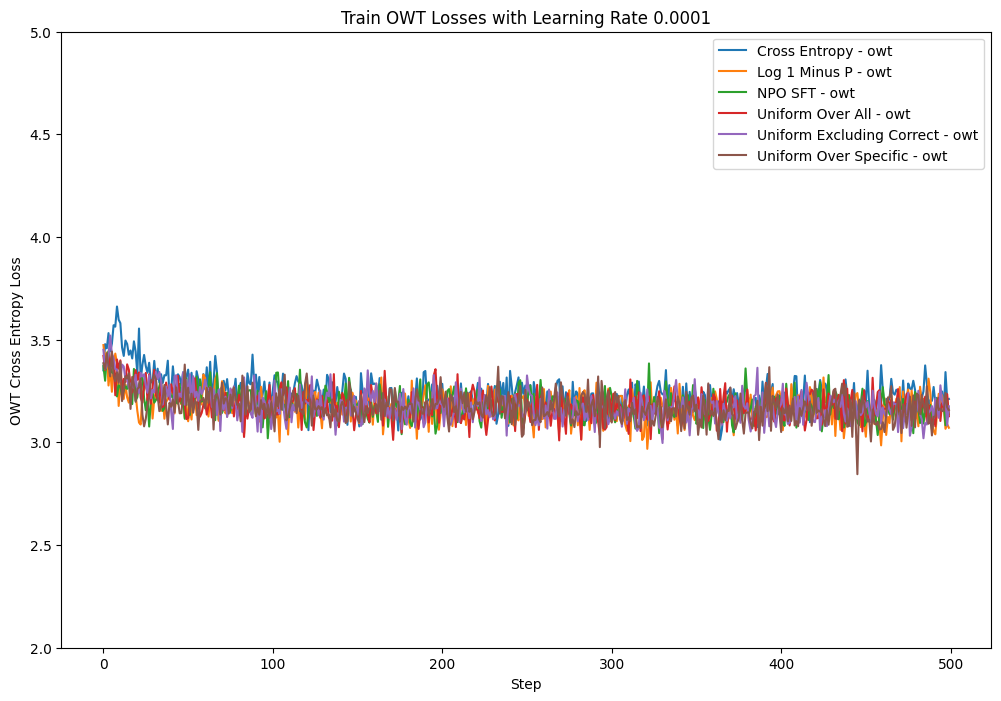

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_train_losses:
    loss_types = all_train_losses[loss_name][0].keys()
    for loss_type in loss_types:
        if "owt" in loss_type:
            plt.plot([x[loss_type] for x in all_train_losses[loss_name]], label=f"{loss_name} - {loss_type}")
plt.ylim(2, 5)
plt.title(f"Train OWT Losses with Learning Rate {lr}")
plt.xlabel("Step")
plt.ylabel("OWT Cross Entropy Loss")
plt.legend()
plt.show()

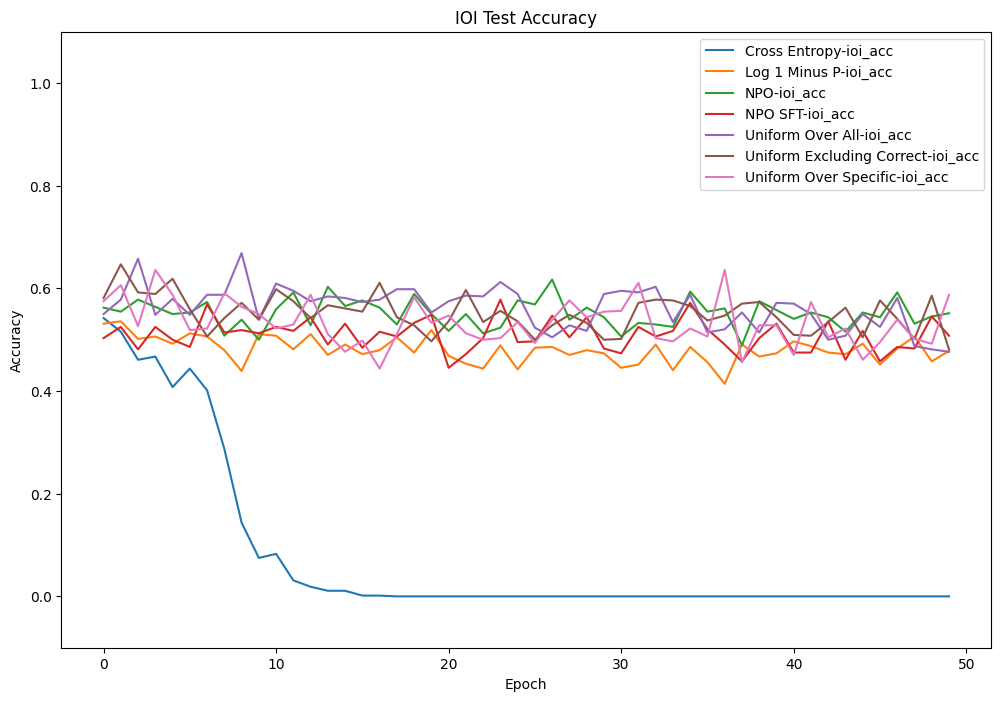

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['ioi_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("IOI Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

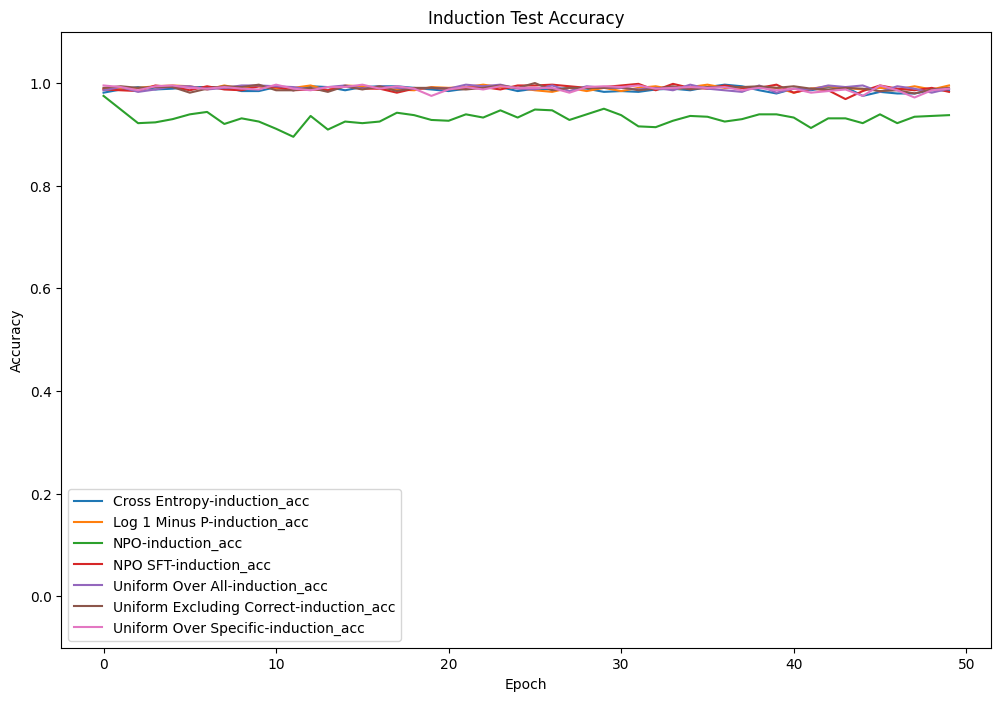

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['induction_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Induction Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

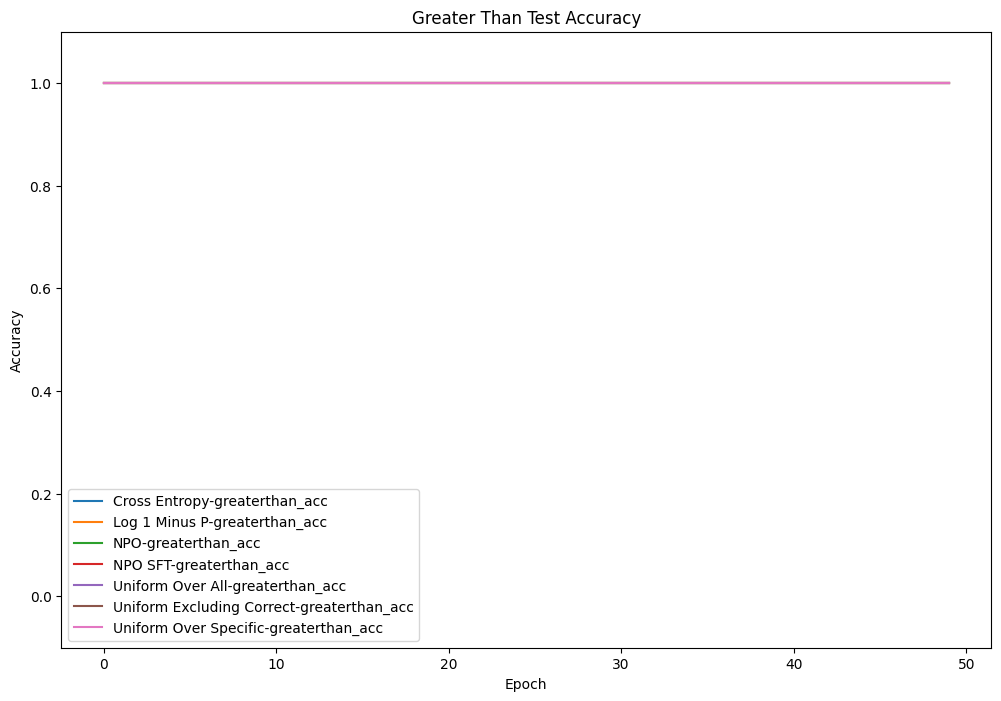

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['greaterthan_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Greater Than Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

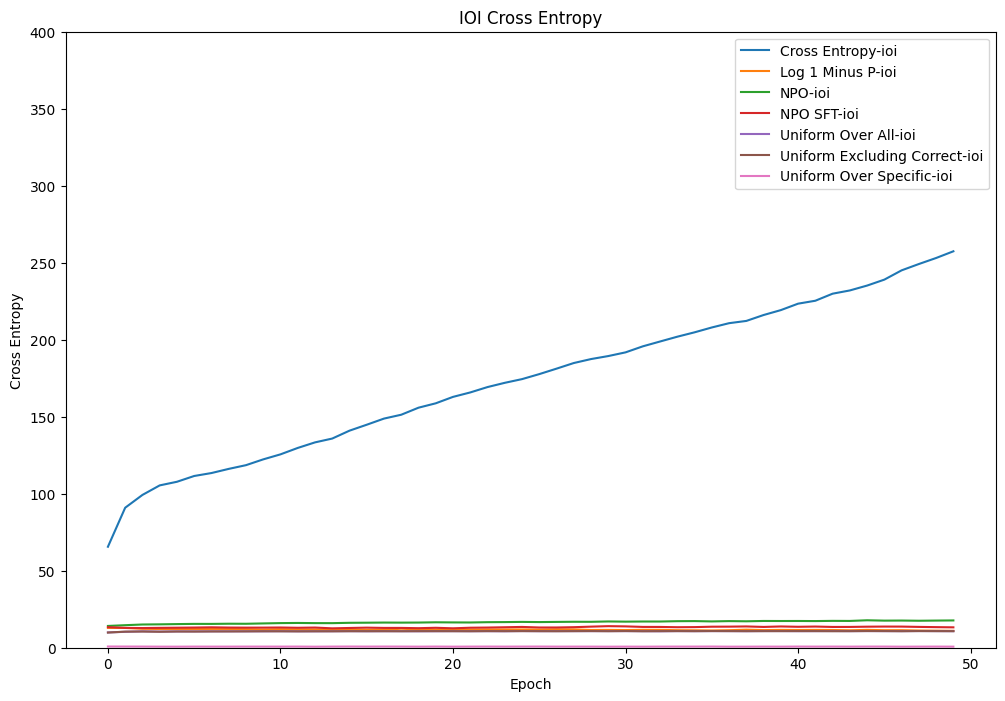

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['ioi']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("IOI Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
# only plot y range from 0 to 3
plt.ylim(0, 400)

plt.show()

In [ ]:
all_test_losses